# Transport Problem: Diffusion

$\frac{\partial c}{\partial t}_x = Df*\left(\frac{\partial^2c}{\partial x^2}\right)$

## Finite-Differences Solution

${c_x}^{t2} ={c_x}^{t1} + mixf*({c_{x-1}}^{t1}-2*{c_{x}}^{t1}+{c_{x+1}}^{t1})$ 

$mixf = \frac{D_f*\Delta t}{(\Delta x)^2}$

Von Neumann criterium: 

$\Delta t \le (\Delta x)^2/(3*D_f)$

Assuming a constant concentration boundary condition $c_0$. The concentration at the neighbouring cell is calculated with the half distances $\Delta x/2$, thus the expression at cell c1 becomes:

${c_1}^{t2} =2*mixf*{c_{0}}^{t1}+mixf*{c_{2}}^{t1}+(1-3*mixf)*{c_{x+1}}^{t1}$ 

This situation requires a new Von-Neumann criterium: $mixf < 2/9$

On the last cell, assuming a no-flow boundary:

${c_n}^{t2} =mixf*{c_{n-1}}^{t1}+(1-mixf)*{c_{n}}^{t1}$ 

## Model

#### libraries

In [25]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### constants

In [26]:
Df = 1e-5 #cm/s
length_x = 1000 #cm
time = 100*365*24*3600 # 100 years in seconds

deltax = 5 # cm
deltat = 5**2/(9*Df)
mixf = Df*deltat/deltax**2


c0 = 0.56

In [27]:
mixf < 2/9

True

#### grid

In [28]:
x = np.arange(deltax/2, length_x, deltax)

#### initial values

In [29]:
c_t0 = np.repeat(0,x.shape)


#### Finite differences scheme:

In [30]:
def iteration(c: np.ndarray, c0: np.float64, mixf):
    result = np.zeros(c.shape)
    # update the fixed boundary:
    result[0] = 2*mixf*c0 + mixf*c[1]+(1-3*mixf)*c[0]
    
    #Update the midow_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(c, (3))
    kernel = np.array([mixf, (1-2*mixf), mixf])
    result[1:-1] = np.dot(sliding_window,kernel)
    
    #Update the last cell:
    result[-1] = mixf*c[-1-1] + (1-mixf)*c[-1]
    
    return result

#### Running model for 100 years:

In [31]:
c = c_t0
dt = np.arange(deltat,time+deltat,deltat)
for i in range(len(dt)):
    c = iteration(c,c0,mixf)

#### Calculating Analytical model:

In [32]:
x_a = np.linspace(length_x,10)

In [33]:
c_a = 0.56*scipy.special.erfc(x_a/np.sqrt(4*Df*time))

#### Plotting and comparing solutions:

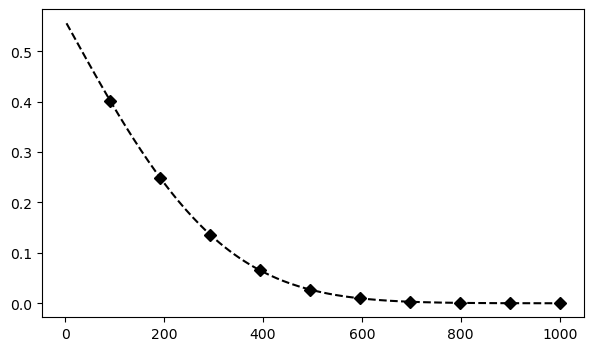

In [48]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(x,c,'--k')
ax.plot(x_a[0::5],c_a[0::5],'Dk')

#### Trying with the implicit scheme:

${c_x}^{t2} ={c_x}^{t1} + mixf*({c_{x-1}}^{t2}-2*{c_{x}}^{t2}+{c_{x+1}}^{t2})$ 

Results in:

$(1-2*mixf){c_x}^{t2} ={c_x}^{t1} + mixf*({c_{x-1}}^{t2}+{c_{x+1}}^{t2})$ 

And we can build our linear system by passing the arguments of $t_2$ to the left hand side:

$-mixf*{c_{x-1}}^{t2}+(1+2*mixf){c_x}^{t2}+(-mixf){c_{x+1}}^{t2} = {c_x}^{t1}$ 

Assuming a constant concentration boundary condition $c_0$. The concentration at the neighbouring cell is calculated with the half distances $\Delta x/2$, thus the expression at cell c1 becomes:

${c_1}^{t2} =2*mixf*{c_{0}}^{t1}+mixf*{c_{2}}^{t1}+(1-3*mixf)*{c_{x+1}}^{t1}$ 

This situation requires a new Von-Neumann criterium: $mixf < 2/9$

On the last cell, assuming a no-flow boundary:

$-mixf*{c_{n-1}}^{t2}+{c_n}^{t2} =(1-mixf)*{c_{n}}^{t1}$ 

In [35]:
def iteration_implicit(c,c0,mixf):
    c = np.concatenate((np.array([c0]),c))
    A = np.zeros((c.shape[0],c.shape[0]))
    #First row: constant concentration
    A[0,0] = 1
    #Second row: update boudnary value
    A[1,0],A[1,1],A[1,2] = [-2*mixf,1+3*mixf,-mixf]
    #Remaining middle rows:
    for i in range(2,A.shape[0]-1):
        A[i,i-1] = -mixf
        A[i,i] = (1+2*mixf)
        A[i,i+1] = -mixf
    #last row:
    A[c.shape[0]-1,c.shape[0]-2],A[c.shape[0]-1,c.shape[0]-1] = [-mixf,1+mixf]
    result = scipy.linalg.solve(A,c)
    result = result[1:]
    return result

#### Running model for 100 years:

In [36]:
Df = 1e-5 #cm/s
length_x = 1000 #cm
time = 100*365*24*3600 # 100 years in seconds

deltax = 5 # cm
deltat = 365*24*3600
mixf = Df*deltat/deltax**2


c0 = 0.56

#### Violating the Von Neumann criterium:

In [37]:
mixf < 2/9

False

#### Running

In [38]:
c_i = c_t0
dt = np.arange(deltat,time+deltat,deltat)
for i in range(len(dt)):
    #t = dt[i]
    c_i = iteration_implicit(c_i,c0,mixf)


#### Plotting and comparing solutions:

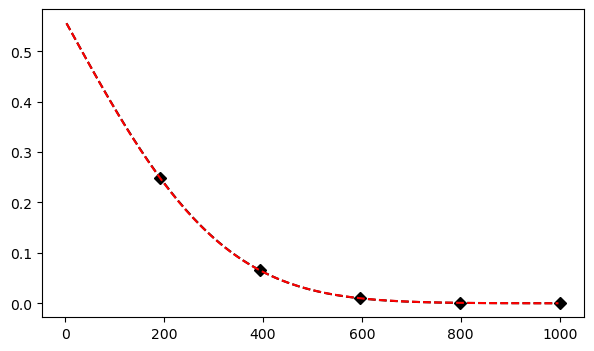

In [39]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(x,c,'--k')
ax.plot(x_a[::10],c_a[::10],'Dk')
ax.plot(x,c_i,'--r')

## Crank-Nicholson scheme

In [40]:
omega = 0.5
deltat <= deltax**2/(4.5*(1-omega)*Df)

False

In [41]:
deltat = deltax**2/(4.5*(1-omega)*Df)/2

In [42]:
deltat <= deltax**2/(4.5*(1-omega)*Df)

True

In [43]:

mixf = Df*deltat/deltax**2

In [44]:
def iteration_crank(c,c0,mixf, omega = 0.5):
    
    #Defining mixf terms for implicit and explicit schemes:
    mixfe = mixf*(1-omega)
    mixfi = mixf*omega
    # Calculating the Explicit-part:
    last_term = np.zeros(c.shape)
    # update the fixed boundary:
    last_term[0] = 2*mixfe*c0 + mixfe*c[1] + (1-3*mixfe)*c[0]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(c, (3))
    kernel = np.array([mixfe, 1-2*mixfe, mixfe])
    last_term[1:-1] = np.dot(sliding_window,kernel)
    
    #Update the last cell:
    last_term[-1] = mixfe*c[-1-1] + (1-mixfe)*c[-1] 
    
    #Calculating the implicit part:
    
    c = np.concatenate((np.array([c0]),last_term))
    A = np.zeros((c.shape[0],c.shape[0]))
    #First row: constant concentration
    A[0,0] = 1
    #Second row: update boundary value
    A[1,0],A[1,1],A[1,2] = [-2*mixfi,1+3*mixfi,-mixfi]
    #Remaining middle rows:
    for i in range(2,A.shape[0]-1):
        A[i,i-1] = -mixfi
        A[i,i] = (1+2*mixfi)
        A[i,i+1] = -mixfi
    #last row:
    A[c.shape[0]-1,c.shape[0]-2],A[c.shape[0]-1,c.shape[0]-1] = [-mixfi,1+mixfi]
    
    #RHS of the system of linear equations, with explicit formulation:
    b = np.concatenate((np.array([c0]),last_term))
    
    #Solving the system of equations:
    result = scipy.linalg.solve(A,b)
    result = result[1:]
    return result

#### Running

In [45]:
c_r = c_t0
dt = np.arange(deltat,time+deltat,deltat)
for i in range(len(dt)):
    t = dt[i]
    c_r = iteration_crank(c_r,c0,mixf, omega)


#### Plotting and comparing solutions:

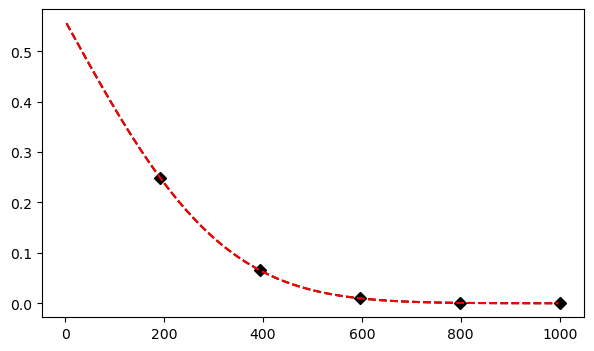

In [46]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(x,c,'--k')
ax.plot(x_a[::10],c_a[::10],'Dk')
ax.plot(x,c_r,'--r')